In [25]:
import sys
sys.path.append('..')
from pathlib import Path
from datetime import datetime
from dateutil import tz
from glob import glob

import matplotlib.patches as mpatches
import geopandas
from cartopy import crs as ccrs

from download_shapes import get_data
from Map import Map

In [30]:
LOCATION = 'tropical_atlantic'

In [31]:
def get_gdf():
    '''Download Tropical Weather Outlooks and read-in files'''
    get_data()
    cat_gdf = geopandas.read_file(glob('data/gtwo_areas_*.shp')[0], bbox=(-100,50,-20,5))
    origin_points = geopandas.read_file(glob('data/gtwo_points_*.shp')[0], bbox=(-100,30,-20,5))
    line_path = geopandas.read_file(glob('data/gtwo_lines_*.shp')[0], bbox=(-100,30,-20,5))
    
    return {
        'areas': cat_gdf,
        'origin_points': origin_points,
        'line_path': line_path
    }
    
cat_gdf = get_gdf()

In [32]:
def nhc_outlook_categories():
    cat_plot_colors = {'Low': 'yellow',
                       'Medium': 'orange',
                       'High': 'red'}
    return cat_plot_colors

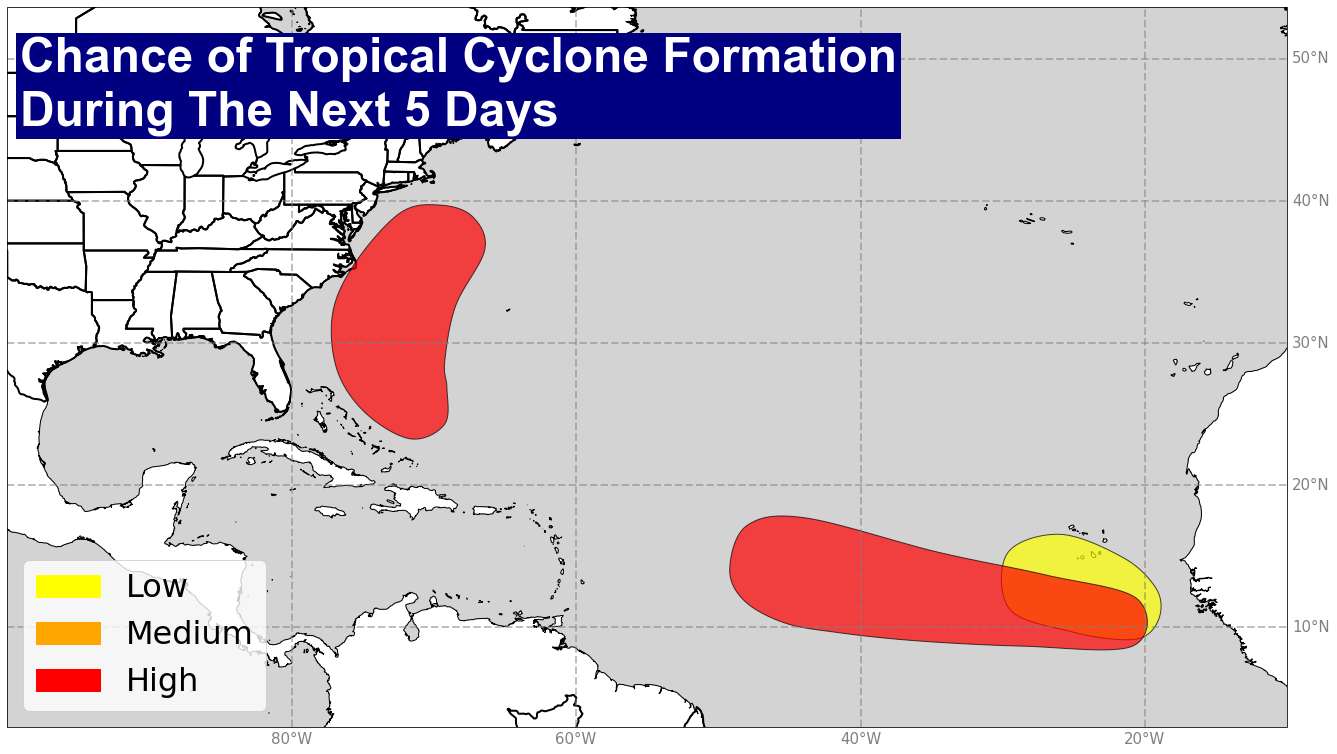

In [35]:
def plot_legend(ax):
    cat_plot_colors = nhc_outlook_categories()
    legend_patches = []
    for val in cat_plot_colors.keys():
        patch = mpatches.Patch(color=cat_plot_colors[val], label=val)
        legend_patches.append(patch)
    ax.legend(handles=legend_patches, fontsize=32, loc='lower left').set_zorder(15)
    
def save_map_to_disk(plt):
    GRAPHICS_DIR = Path('.') / '..' / '..' / 'graphics' / 'nhc'
    plt.savefig(f'{GRAPHICS_DIR}/twoat_{LOCATION}.png', dpi=72)

def is_development_area(geometries):
    '''Checks to see if there are any areas flagged for tropical development'''
    return True if cat_gdf['areas']['geometry'].any() else False

def plot_risk_areas(ax):  
    '''Plots tropical cyclone development potential areas over next 5 days'''
    cat_plot_colors = nhc_outlook_categories()
    for key in cat_plot_colors.keys():
        geometries = cat_gdf['areas'][cat_gdf['areas']['RISK5DAY'] == key]
        ax.add_geometries(geometries['geometry'], crs=ccrs.PlateCarree(),
                          facecolor=cat_plot_colors[key], edgecolor='black',
                          alpha=0.7)
        
def plot_origin_points(ax):
    '''Plots current area of interest'''
    points = cat_gdf['origin_points']['geometry']
    
    ax.scatter([point.x for point in points], 
               [point.y for point in points],
               c='black', marker='X', s=300, zorder=2,
               transform=ccrs.PlateCarree())
    
def plot_origin_to_development(ax):
    '''
    Plots a line connecting the current area of interest
    with a potential development area over the next 5 days
    '''
    ax.add_geometries(cat_gdf['line_path']['geometry'], crs=ccrs.PlateCarree(), 
                      facecolor='none', edgecolor='black', linewidth=3, zorder=4, 
                      linestyle='dashed')
    
def plot_tropical_outlook():
    '''Plots the entire graphical Tropical Weather Outlook if there are areas of interest'''
    if not is_development_area(cat_gdf['areas']['geometry']):
        return

    new_map = Map(LOCATION)
    new_map.remove_international_states()
    new_map.add_latlon_lines()
    new_map.add_title(f'Chance of Tropical Cyclone Formation\nDuring The Next 5 Days')

    fig, ax = new_map.make_map()
    
    plot_risk_areas(ax)
    plot_legend(ax)
    #plot_origin_points(ax)
    plot_origin_to_development(ax)
    save_map_to_disk(fig)


plot_tropical_outlook()